In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [ ]:
datasize = 50
min_document_length = 128
max_document_length = 512


index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [12]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: alt.atheism
yes but whose freedom the world in general doesn t seem to value the freedom of tibetan for example


In [13]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


In [14]:
print(f"there are {len(train_docs)} docs")

there are 200 docs


### Initialize Vectorizer

In [15]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 1080


### Prepare Datatset

In [16]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

200 train_docs


### Word-Word Ratio

In [17]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
#     word_word_co[word] = np.log1p(pxy / (probability[word] * probability))
#     word_word_co[word] = pxy / (probability[word] * probability)
    word_word_co[word] = pxy / probability[word]

word_word_co -= word_word_co.min().min()
word_word_co /= word_word_co.max().max()
print(f"word_word_co has shape {word_word_co.shape}")


word_word_co has shape (1080, 1080)


In [18]:
word_word_co.head()

,00,0565,10,101,10k,11,16k,17,1760,1962,...,year,yes,yet,yo,you,your,ypu,yup,yuppie,zbib
00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
0565,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.0,0.0
10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
10k,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


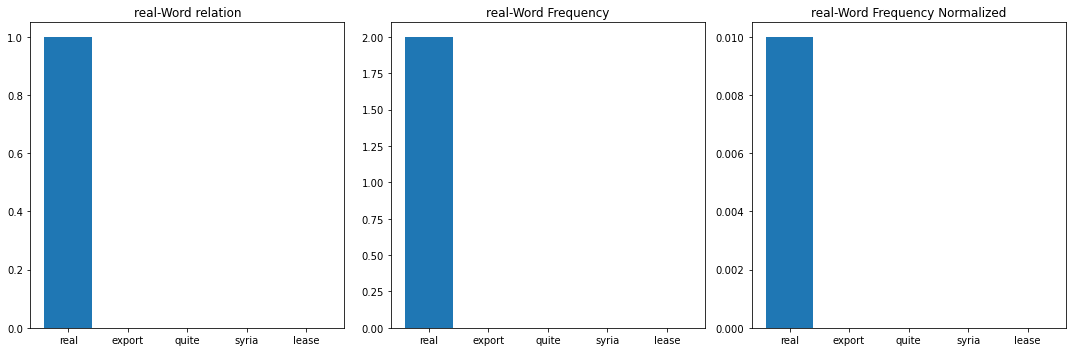

In [20]:
# word = "car"
# words = ["the", "driver", "usually", "software", "window"]

words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]
word = words[0]

fig = plt.figure(figsize=(15,5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word}-Word relation")
ax11.bar(words, word_word_co.loc[word][words])

pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0)

ax12.set_title(f"{word}-Word Frequency")
ax12.bar(words, pxy[words])

pxy /= total_num_of_documents

ax13.set_title(f"{word}-Word Frequency Normalized")
ax13.bar(words, pxy[words])

plt.show()

## reduce word dimensions

In [21]:
delta = word_weight.std()
delta = word_weight.mean()*.1

threshold = word_weight.mean()
selected_best_words = word_weight[word_weight >= threshold].index

# while word_doc_frequency_norm[selected_best_words].mean(1).eq(0).any().any():
#     selected_best_words = word_weight[word_weight >= threshold].index
#     threshold -= word_weight.std()
    
# word_word_co = word_word_co[selected_best_words]
# word_doc_frequency_norm = word_doc_frequency_norm[selected_best_words]

print(f"using only {len(selected_best_words)} best word(s)")

NameError: name 'word_weight' is not defined

In [22]:
word_weight = word_word_co.mean(0).sort_values(ascending=False)
best_words = word_weight.index

for word_index in tqdm(range(1, len(word_weight))):
    selected_best_words = best_words[:word_index]
    if not word_doc_frequency_norm[selected_best_words].mean(1).eq(0).any().any():
        break

# word_word_co = word_word_co[selected_best_words]
# word_doc_frequency_norm = word_doc_frequency_norm[selected_best_words]

print(f"using only {len(selected_best_words)} best word(s)")
print(selected_best_words[:10])


using only 1079 best word(s)
Index(['howell', 'ampr', '210', 'rid', 'george', 'goucher', 'org', 'dang',
       'wb3ffv', 'quest'],
      dtype='object')


In [23]:
word_doc_frequency_norm[selected_best_words].mean(1).eq(0).any().any()

True

In [24]:
word_doc_frequency_norm[selected_best_words].mean(1).sort_values(ascending=True)

104    0.000000
35     0.000000
22     0.000927
130    0.000927
187    0.000927
         ...   
77     0.000927
78     0.000927
70     0.000927
133    0.000927
57     0.000927
Length: 200, dtype: float64

In [25]:
index = 104
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: alt.atheism
deletion


### Setup Doc Word Distr

In [587]:
number_of_iterations = 1
doc_word_distr = pd.DataFrame(data=0.0, columns=selected_best_words, index=range(total_num_of_documents))

total_iterations = number_of_iterations * total_num_of_documents

with tqdm(total=total_iterations) as pbar:
    for n_iter in range(number_of_iterations):
        for doc_index in (range(total_num_of_documents)):
            
            words = selected_best_words[word_doc_frequency_norm.loc[doc_index] > 0]
            doc_word_distr.loc[doc_index] = (word_doc_frequency_norm.loc[doc_index] * word_word_co.loc[words]).mean()
            pbar.update(1)
            
        print(f"overall probability sum in docs {doc_word_distr.sum().sum()}")

overall probability sum in docs 42.786855432098164
overall probability sum in docs 42.786855432098164


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "c:\users\christian\documents\christian\work\python\cyberspace\topic_modeler\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-587-1d55b4fdae64>", line 12, in <module>
    doc_word_distr.loc[doc_index] = (word_doc_frequency_norm.loc[doc_index] * word_word_co.loc[words]).mean()
  File "c:\users\christian\documents\christian\work\python\cyberspace\topic_modeler\venv\lib\site-packages\pandas\core\ops\__init__.py", line 776, in f
    self, other, pass_op, fill_value=fill_value, axis=axis, level=level
  File "c:\users\christian\documents\christian\work\python\cyberspace\topic_modeler\venv\lib\site-packages\pandas\core\ops\__init__.py", line 622, in _combine_series_frame
    return left._construct_result(new_data)
  File "c:\users\christian\documents\christian\work\python\cyberspace\topic_modeler\venv\lib\site-packages\pandas\core\frame.py", l

TypeError: object of type 'NoneType' has no len()

In [583]:
print(doc_word_distr.sum().sum())

42.786855432098164


In [418]:
doc_word_distr.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
doc_index = 254
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(5)

ites      1.0
zuma      0.0
expel     0.0
expect    0.0
exists    0.0
Name: 254, dtype: float64

In [93]:
doc_word_distr.loc[doc_index].sort_values(ascending=False).head(5)

NameError: name 'doc_word_distr' is not defined

In [421]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: sci.space
it s my understand that the freeze will start to occur because of the grow distance of pluto and charon from the sun due to it s elliptical orbit it be not due to shadow effect pluto can shadow charon and vice versa george krumins


### Define Latent partitions

In [559]:
reduction = None
# reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 4
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=False)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.sum(1), doc_word_distr.mean(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 2727)


In [560]:
distr_params.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using Kmeans MiniBatch

In [567]:
num_of_topics = 4

In [568]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [569]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [570]:
Counter(predicted_labels)

Counter({0: 396, 2: 2, 3: 1, 1: 1})

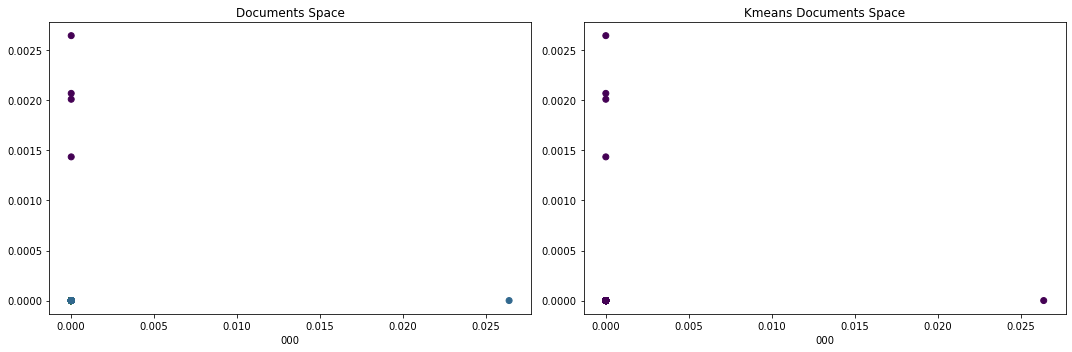

In [571]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [572]:
def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [573]:
get_top(0)

Counter({'talk.politics.mideast': 100, 'rec.autos': 99, 'sci.space': 99, 'alt.atheism': 98})
ironic          0.000654
humanist        0.000641
dear            0.000461
45th            0.000419
birthday        0.000419
childish        0.000402
propagandist    0.000402
davidsson       0.000337
happy           0.000271
grow            0.000253
dtype: float64


In [530]:
get_top(1)

Counter({'sci.space': 41, 'talk.politics.mideast': 39, 'rec.autos': 37, 'alt.atheism': 19})
asshole          0.000715
5sp              0.000612
ypu              0.000456
sue              0.000456
clearify         0.000455
contradiction    0.000400
reconcile        0.000400
apparent         0.000400
90vanagon        0.000395
anal             0.000383
dtype: float64


In [531]:
get_top(2)

Counter({'sci.space': 1, 'rec.autos': 1})
ites           0.50
sherzer        0.25
methodology    0.25
zuma           0.00
expel          0.00
exists         0.00
exist          0.00
exhibit        0.00
exhaust        0.00
exempt         0.00
dtype: float64


In [532]:
get_top(3)

Counter({'alt.atheism': 77, 'rec.autos': 56, 'talk.politics.mideast': 50, 'sci.space': 47})
bet          0.000197
life         0.000196
retard       0.000181
be           0.000161
message      0.000160
shrink       0.000159
definetly    0.000159
loser        0.000145
delete       0.000143
the          0.000143
dtype: float64


### LDA